In [38]:
######################################CONSTANTS######################################
num_samples = 1000
LINEWIDTH = 13.97
import sys

sys.path.insert(0, '..')

from typing import Dict, Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from data_utils import DATAFILE_LIST, prepare_data, NUM_CLASSES_DICT, FIGURE_DIR, DATASET_NAMES, TOPK_DICT, CIFAR100_CLASSES
from models import BetaBernoulli, ClasswiseEce
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'

In [93]:
def plot_scatter(ax: mpl.axes.Axes,
                 accuracy_samples: np.ndarray,
                 ece_samples: np.ndarray,
                 limit=5) -> mpl.axes.Axes:
    # plot
    x = np.mean(accuracy_samples, axis=1)
    y = np.mean(ece_samples, axis=1)
    xerr = np.std(accuracy_samples, axis=1)
    yerr = np.std(ece_samples, axis=1)

    # most accuracy top k
    idx = x.argsort()[-limit:][::-1]
    ax.errorbar(x[idx], y[idx],
                xerr=xerr[idx],
                yerr=yerr[idx],
                fmt='o', alpha=0.8, color='b')

    # least accuracy top k
    idx = x.argsort()[:limit]
    ax.errorbar(x[idx], y[idx],
                xerr=xerr[idx],
                yerr=yerr[idx],
                fmt='o', alpha=0.8, color='r')

    # other predicted classes
    idx = x.argsort()[limit:-limit]
    ax.errorbar(x[idx], y[idx],
                xerr=xerr[idx],
                yerr=yerr[idx],
                fmt='o', alpha=0.2, color='k')

    return ax


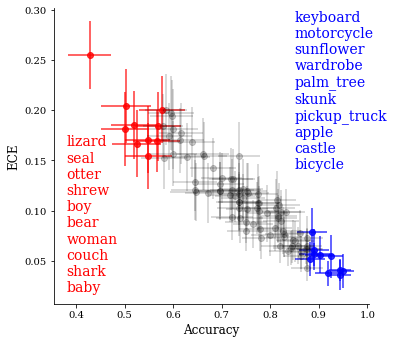

In [107]:
dataset = 'cifar100'
datafile = DATAFILE_LIST[dataset]
num_classes = NUM_CLASSES_DICT[dataset]

categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)

# accuracy models
accuracy_model = BetaBernoulli(k=num_classes, prior=None)
accuracy_model.update_batch(categories, observations)

# ece models for each class
ece_model = ClasswiseEce(num_classes, num_bins=10, pseudocount=2)
ece_model.update_batch(categories, observations, confidences)

# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples)  # (num_categories, num_samples)
ece_samples = ece_model.sample(num_samples)  # (num_categories, num_samples)

fig, ax = plt.subplots(figsize=(LINEWIDTH/2*0.8,LINEWIDTH/2*0.7))
limit=TOPK_DICT[dataset]
ax = plot_scatter(ax, accuracy_samples, ece_samples, limit=limit)
#ax.set_title(DATASET_NAMES[dataset])

ax.set_ylabel('ECE', fontsize=12)
ax.set_xlabel('Accuracy', fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

labels=CIFAR100_CLASSES
sort_indices = np.argsort(np.mean(accuracy_samples, axis=1))
if labels is not None:
    labels = [labels[i] for i in sort_indices]

labels_string = ('%s\n' * limit ) % tuple(labels[0:limit])
ax.text(0.38, 0, labels_string, fontsize=14, color='r',verticalalignment='bottom')
labels_string = ('%s\n' * limit ) % tuple(labels[-limit:][::-1])
ax.text(0.85, 0.3, labels_string, fontsize=14, color='b',verticalalignment='top')
fig.tight_layout()

In [108]:
figname = FIGURE_DIR + 'cifar100_scatter.pdf'
fig.savefig(figname, bbox_inches='tight', pad_inches=0)

In [98]:
def plot_scatter_all():
    
    fig, axes = plt.subplots(ncols=5, nrows=1, dpi=300, sharey=False)
    idx = 0
    for dataset in DATASET_NAMES:
        datafile = DATAFILE_LIST[dataset]
        num_classes = NUM_CLASSES_DICT[dataset]

        categories, observations, confidences, idx2category, category2idx, labels = prepare_data(datafile, False)

        # accuracy models
        accuracy_model = BetaBernoulli(k=num_classes, prior=None)
        accuracy_model.update_batch(categories, observations)
        # ece models for each class
        ece_model = ClasswiseEce(num_classes, num_bins=10, pseudocount=2)
        ece_model.update_batch(categories, observations, confidences)

        # draw samples from posterior of classwise accuracy
        accuracy_samples = accuracy_model.sample(num_samples)  # (num_categories, num_samples)
        ece_samples = ece_model.sample(num_samples)  # (num_categories, num_samples)

        plot_kwargs = {}
        axes[idx] = plot_scatter(axes[idx], accuracy_samples, ece_samples, limit=TOPK_DICT[dataset])
        axes[idx].set_title(DATASET_NAMES[dataset])
        idx += 1
        
    return fig, axes

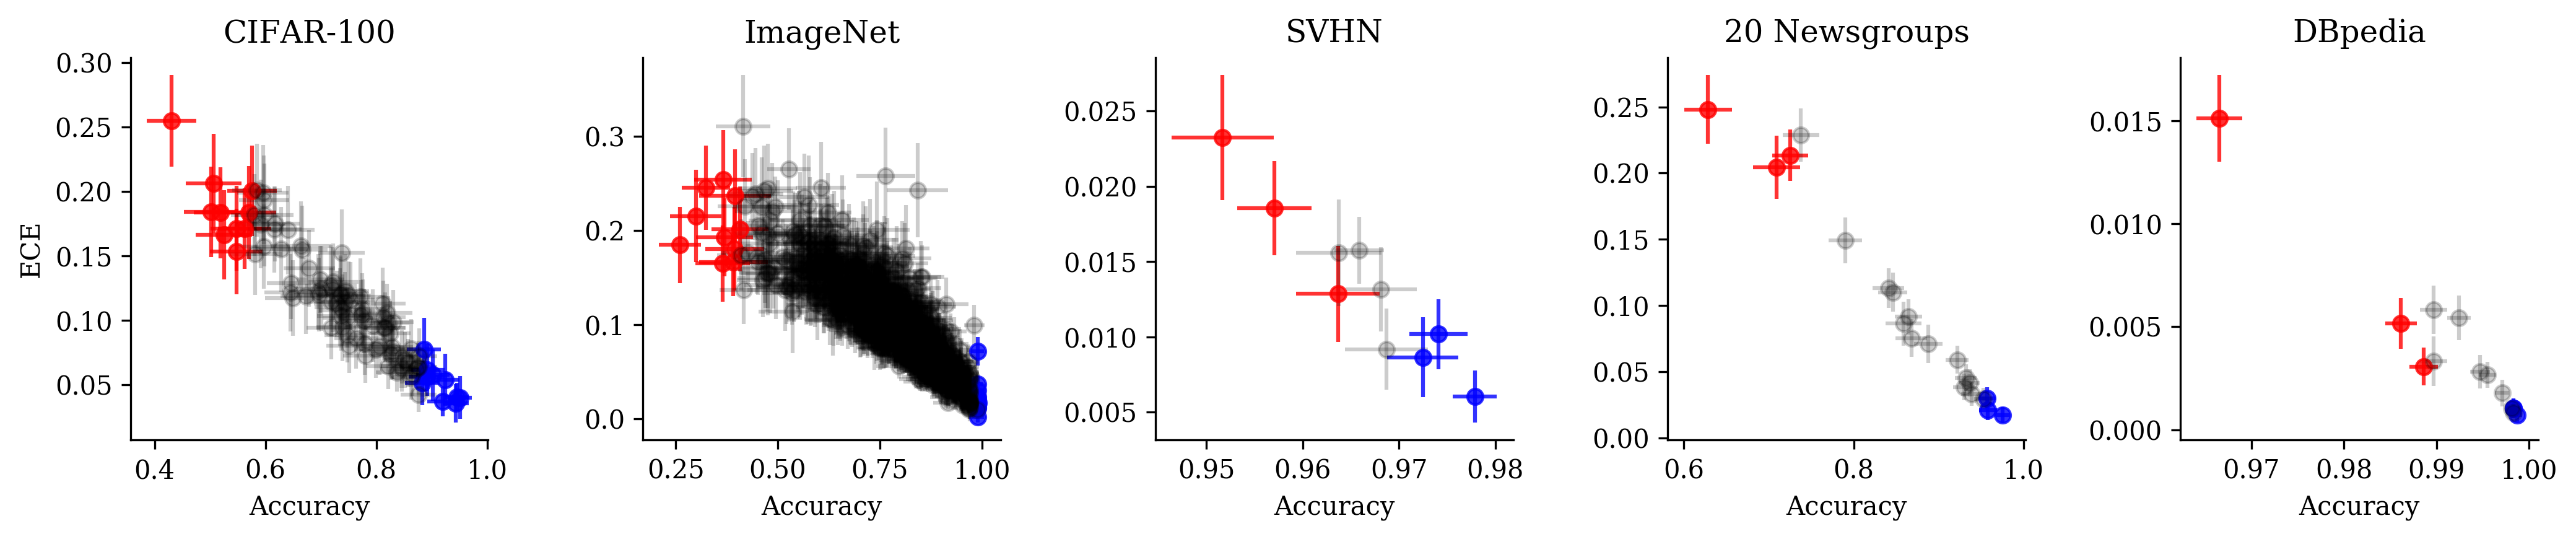

In [99]:
fig, axes = plot_scatter_all()
axes[0].set_ylabel('ECE')
for idx in range(5):
    axes[idx].set_xlabel('Accuracy')
    axes[idx].spines['right'].set_visible(False)
    axes[idx].spines['top'].set_visible(False)
fig.set_size_inches(LINEWIDTH, 3.0)
fig.tight_layout()
fig.savefig(FIGURE_DIR + 'scatter_all.pdf', bbox_inches='tight', pad_inches=0)